In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import plotly.graph_objects as go

In [2]:
# Loading the dataset
filepath = f'fake reviews dataset.csv'  # Path to the dataset file
df = pd.read_csv(filepath)  # Reading the CSV file into a pandas DataFrame

# Downloading NLTK stopwords (commonly used words like "is", "the", "and", etc.)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))    # Creating a set of English stopwords for filtering

# Function to clean the text data
def preprocess_text(text):
    text = text.lower()     # Convert all text to lowercase for uniformity
    # Remove all stopwords from the text
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Applying the preprocessing function to each review
# 'text_' is the original column; the cleaned version is stored in 'review'
df['review'] = df['text_'].apply(preprocess_text)
# Separating the features and labels
X = df['review']  # Input text data (cleaned)
y = df['label']   # Output labels (e.g., 0 for fake, 1 for real)

# Encoding the labels into numeric format (in case they are categorical)
encoder = LabelEncoder()
y = encoder.fit_transform(y)  # Converts string labels to integers (e.g., "fake" to 0, "real" to 1)
print(y)  # Displaying the encoded labels

# Splitting the dataset into training and testing sets
# 80% of the data is used for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(10, 7))  # Set the figure size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # Plot the confusion matrix with annotations
    plt.title(f'{model_name} Confusion Matrix')  # Title of the plot
    plt.xlabel('Predicted')  # Label for x-axis
    plt.ylabel('Actual')     # Label for y-axis
    plt.show()  # Display the plot

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hamza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[0 0 0 ... 1 0 1]


In [3]:
# vectorize the text data

# Creating a TF-IDF Vectorizer object to convert text into numerical features
# TF-IDF stands for Term Frequency - Inverse Document Frequency
# It helps identify important words in the review based on how frequently they appear across documents
# max_features=5000 means we are only keeping the top 5000 most relevant words
vectorizer = TfidfVectorizer(max_features=5000)

# Fitting the vectorizer on training data and transforming the text into a numerical matrix
# 'fit_transform' learns the vocabulary from training data and converts it into a TF-IDF matrix
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transforming the test data using the same vocabulary learned from training data
# Only 'transform' is used here to ensure consistency with training vocabulary
X_test_tfidf = vectorizer.transform(X_test)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4016
           1       0.87      0.89      0.88      4071

    accuracy                           0.88      8087
   macro avg       0.88      0.88      0.88      8087
weighted avg       0.88      0.88      0.88      8087

Logistic Regression Confusion Matrix:
[[3491  525]
 [ 433 3638]]


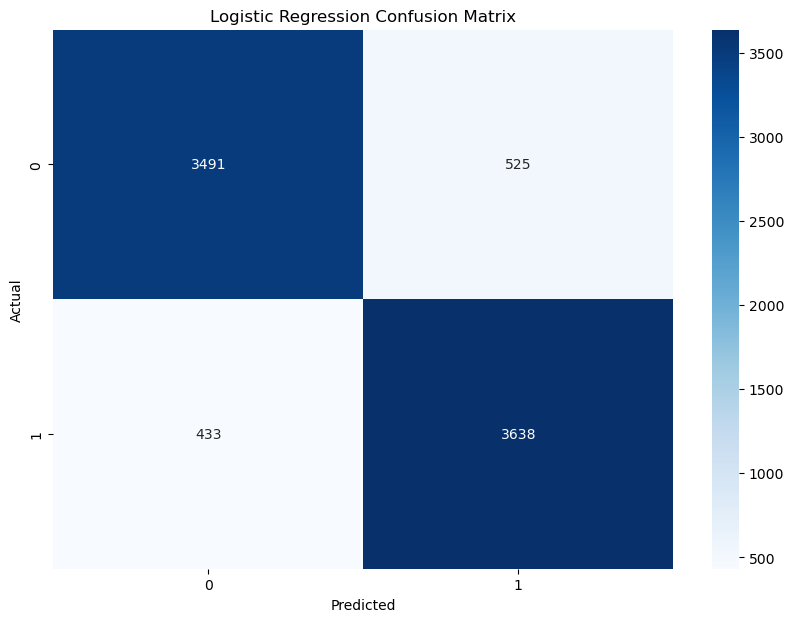

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      4016
           1       0.88      0.92      0.90      4071

    accuracy                           0.90      8087
   macro avg       0.90      0.90      0.90      8087
weighted avg       0.90      0.90      0.90      8087

SVM Confusion Matrix:
[[3528  488]
 [ 345 3726]]


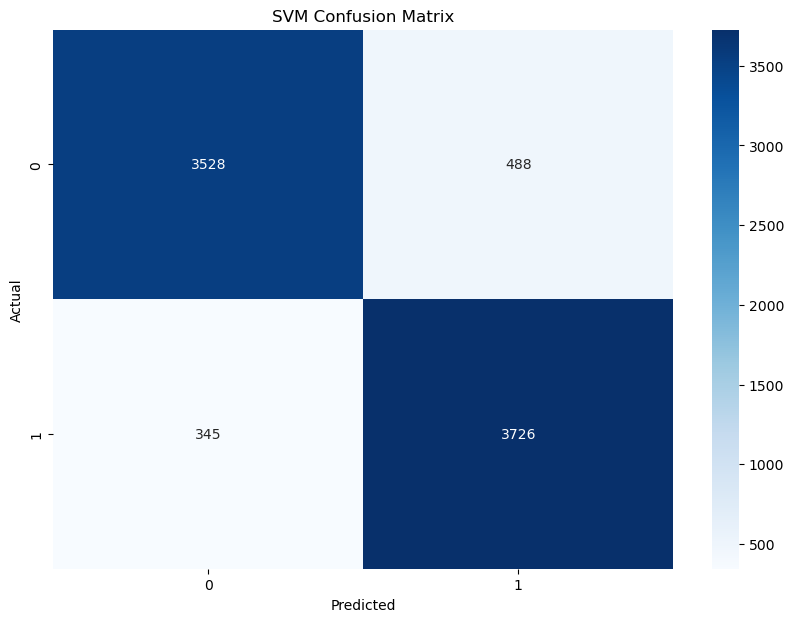

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      4016
           1       0.88      0.82      0.85      4071

    accuracy                           0.85      8087
   macro avg       0.85      0.85      0.85      8087
weighted avg       0.85      0.85      0.85      8087

Random Forest Confusion Matrix:
[[3561  455]
 [ 735 3336]]


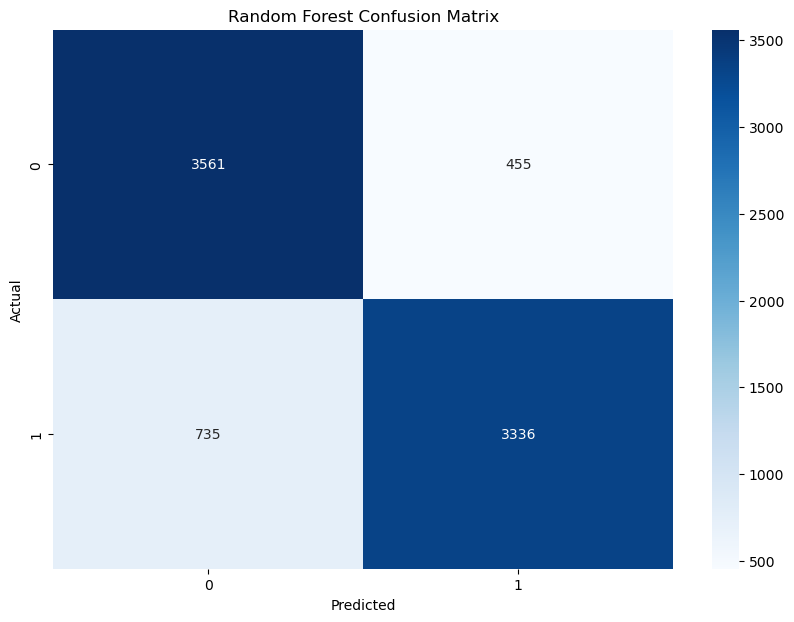

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4016
           1       0.84      0.88      0.86      4071

    accuracy                           0.86      8087
   macro avg       0.86      0.86      0.86      8087
weighted avg       0.86      0.86      0.86      8087

XGBoost Confusion Matrix:
[[3321  695]
 [ 476 3595]]


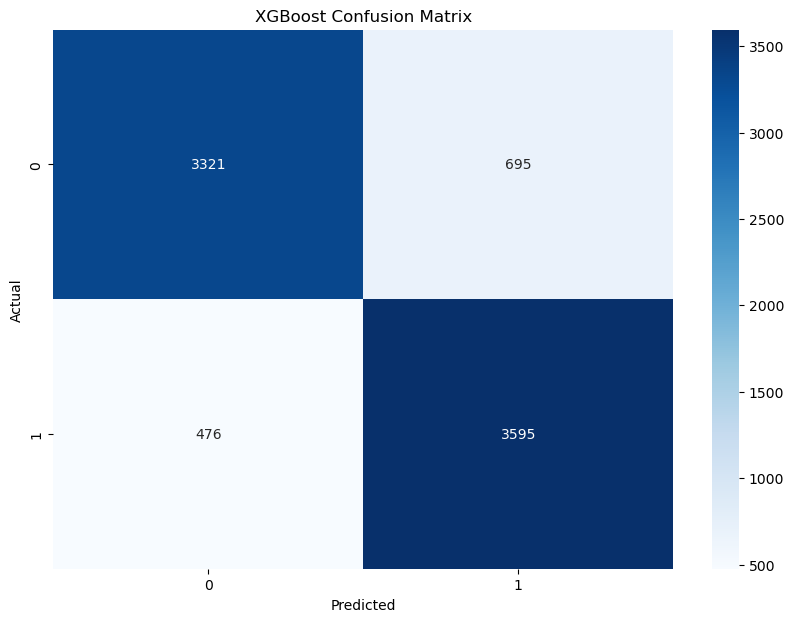

In [4]:
# Function to train and evaluate multiple classification models
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    
    # Dictionary containing different machine learning models for comparison
    models = {
        'Logistic Regression': LogisticRegression(),       # Linear model used for binary classification
        'SVM': SVC(),                                       # Support Vector Machine - good for text classification
        'Random Forest': RandomForestClassifier(),          # Ensemble method using decision trees
        'XGBoost': XGBClassifier()                          # Gradient boosting model - efficient and powerful
    }

    # Dictionary to store the accuracy of each model
    accuracies = {}

    # Loop through each model in the dictionary
    for model_name, model in models.items():
        
        # Train the model on training TF-IDF features and training labels
        model.fit(X_train_tfidf, y_train)
        
        # Predict the labels for the test set
        y_pred = model.predict(X_test_tfidf)

        # Store the accuracy score of the current model
        accuracies[model_name] = accuracy_score(y_test, y_pred)

        # Print detailed classification report including precision, recall, F1-score
        print(f'{model_name} Classification Report:\n{classification_report(y_test, y_pred)}')
        
        # Generate the confusion matrix comparing predicted vs actual labels
        cm = confusion_matrix(y_test, y_pred)
        
        # Print the confusion matrix in console
        print(f'{model_name} Confusion Matrix:\n{cm}')
        
        # Call function to plot confusion matrix visually
        plot_confusion_matrix(cm, model_name)

    # Return the dictionary containing model names and their accuracy scores
    return accuracies

# Call the function to train and evaluate all models, and store their accuracies
model_accuracies = train_and_evaluate_models(X_train, X_test, y_train, y_test)

In [5]:
# Selects GPU if available, otherwise defaults to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert the TF-IDF feature matrices to PyTorch tensors and move them to the selected device
X_train_tensor = torch.FloatTensor(X_train_tfidf.toarray()).to(device)  # Training features
X_test_tensor = torch.FloatTensor(X_test_tfidf.toarray()).to(device)    # Testing features
y_train_tensor = torch.FloatTensor(y_train).to(device)                  # Training labels
y_test_tensor = torch.FloatTensor(y_test).to(device)                    # Testing labels

# Define an LSTM-based neural network model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=250, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer: processes sequences of input data
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Dropout layer: helps prevent overfitting by randomly turning off neurons
        self.dropout = nn.Dropout(0.3)
        
        # Fully connected layer: maps LSTM output to final prediction
        self.fc = nn.Linear(hidden_size, 1)
        
        # Sigmoid activation: converts output to probability (0 to 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Add a sequence dimension to the input (needed for LSTM)
        x = x.unsqueeze(1)
        
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Pass the input through LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Take output from the last time step and apply dropout
        out = self.dropout(out[:, -1, :])
        
        # Pass through fully connected layer
        out = self.fc(out)
        
        # Convert to probability using sigmoid
        out = self.sigmoid(out)
        
        # Remove unnecessary dimensions for output
        return out.squeeze()

In [6]:
# Create an instance of the LSTM model with input size equal to number of TF-IDF features
model = LSTMModel(input_size=X_train_tfidf.shape[1]).to(device)

# Define binary cross-entropy loss for binary classification
criterion = nn.BCELoss()

# Use Adam optimizer for efficient training
optimizer = torch.optim.Adam(model.parameters())

# Set training parameters
num_epochs = 50         # Number of times the model will see the full dataset
batch_size = 128          # Number of samples processed before the model is updated

# Prepare DataLoader for efficient mini-batch training
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# List to keep track of training loss after each epoch
train_losses = []

# Set the model to training mode
model.train()

# Start training loop
for epoch in range(num_epochs):
    total_loss = 0.0  # Track loss for the current epoch
    
    # Iterate over mini-batches
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()           # Clear previous gradients
        outputs = model(batch_X)        # Forward pass
        loss = criterion(outputs, batch_y)  # Compute loss
        loss.backward()                 # Backpropagation
        optimizer.step()                # Update model weights
        total_loss += loss.item()       # Accumulate batch loss
    
    # Compute average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)       # Store the epoch loss
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')  # Display progress

# Save the trained model's state dictionary to disk
torch.save(model.state_dict(), 'lstm_model_pytorch.pth')

# Set the model to evaluation mode before inference
model.eval()
with torch.no_grad():  # Disable gradient calculation for evaluation
    test_outputs = model(X_test_tensor)                     # Predict on test data
    predictions = (test_outputs > 0.5).float()              # Convert probabilities to binary predictions
    accuracy = (predictions == y_test_tensor).float().mean()  # Compute average accuracy
    print(f'Test Accuracy: {accuracy:.4f}')                 # Display test accuracy

Epoch [1/50], Loss: 0.4474
Epoch [2/50], Loss: 0.2484
Epoch [3/50], Loss: 0.2193
Epoch [4/50], Loss: 0.2055
Epoch [5/50], Loss: 0.1961
Epoch [6/50], Loss: 0.1899
Epoch [7/50], Loss: 0.1846
Epoch [8/50], Loss: 0.1810
Epoch [9/50], Loss: 0.1757
Epoch [10/50], Loss: 0.1725
Epoch [11/50], Loss: 0.1683
Epoch [12/50], Loss: 0.1648
Epoch [13/50], Loss: 0.1606
Epoch [14/50], Loss: 0.1562
Epoch [15/50], Loss: 0.1522
Epoch [16/50], Loss: 0.1472
Epoch [17/50], Loss: 0.1421
Epoch [18/50], Loss: 0.1364
Epoch [19/50], Loss: 0.1307
Epoch [20/50], Loss: 0.1231
Epoch [21/50], Loss: 0.1165
Epoch [22/50], Loss: 0.1085
Epoch [23/50], Loss: 0.1010
Epoch [24/50], Loss: 0.0929
Epoch [25/50], Loss: 0.0838
Epoch [26/50], Loss: 0.0762
Epoch [27/50], Loss: 0.0685
Epoch [28/50], Loss: 0.0607
Epoch [29/50], Loss: 0.0528
Epoch [30/50], Loss: 0.0465
Epoch [31/50], Loss: 0.0408
Epoch [32/50], Loss: 0.0351
Epoch [33/50], Loss: 0.0303
Epoch [34/50], Loss: 0.0259
Epoch [35/50], Loss: 0.0227
Epoch [36/50], Loss: 0.0195
E

In [7]:
# Create a new figure for the training loss curve
fig = go.Figure()

# Add a line plot of training loss over epochs
fig.add_trace(go.Scatter(
    x=list(range(1, num_epochs + 1)),  # Epoch numbers on the x-axis
    y=train_losses,                   # Corresponding loss values on the y-axis
    mode='lines+markers',            # Show both lines and data points
    name='Training Loss',            # Legend label
    line=dict(color='royalblue', width=2)  # Line styling
))

# Customize layout of the plot
fig.update_layout(
    title='LSTM Training Loss Curve',     # Chart title
    xaxis_title='Epoch',                  # X-axis label
    yaxis_title='Loss',                   # Y-axis label
    template='plotly_white'               # Use a clean white background style
)

# Display the interactive plot
fig.show()

# HyperParameter Tuning

In [ ]:
# Objective function for Logistic Regression hyperparameter optimization
# This function defines how Optuna will tune the 'C' parameter to maximize model accuracy.
def objective_logistic(trial):
    C = trial.suggest_loguniform('C', 1e-5, 1e2)
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train_tfidf, y_train)   # Train the model
    y_pred = model.predict(X_test_tfidf)    # Predict on test set
    return accuracy_score(y_test, y_pred)   # Return accuracy for evaluation

# Objective function for Support Vector Classifier (SVC) optimization
# Optuna will tune both 'C' (regularization) and 'kernel' (type of SVM kernel) parameters.
def objective_svc(trial):
    C = trial.suggest_loguniform('C', 1e-5, 1e2)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    model = SVC(C=C, kernel=kernel)
    model.fit(X_train_tfidf, y_train)   # Train the model
    y_pred = model.predict(X_test_tfidf)    # Predict on test set
    return accuracy_score(y_test, y_pred)   # Return accuracy for evaluation

# Objective function for Random Forest Classifier optimization
# Optuna will tune 'n_estimators' (number of trees) and 'max_depth' (depth of trees).
def objective_random_forest(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    model.fit(X_train_tfidf, y_train)   # Train the model
    y_pred = model.predict(X_test_tfidf)    # Predict on test set
    return accuracy_score(y_test, y_pred)   # Return accuracy for evaluation

# Objective function for XGBoost Classifier optimization
# Optuna will tune 'n_estimators', 'max_depth', and 'learning_rate' parameters for better model performance.
def objective_xgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
    model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train_tfidf, y_train)   # Train the model
    y_pred = model.predict(X_test_tfidf)    # Predict on test set
    return accuracy_score(y_test, y_pred)   # Return accuracy for evaluation


In [ ]:

# Create and run Optuna study for Logistic Regression
study_logistic = optuna.create_study(direction='maximize')  # We want to maximize accuracy
study_logistic.optimize(objective_logistic, n_trials=5)    # Run 5 trials

# Create and run Optuna study for Support Vector Classifier
study_svc = optuna.create_study(direction='maximize')
study_svc.optimize(objective_svc, n_trials=5)

# Create and run Optuna study for Random Forest
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_random_forest, n_trials=5)

# Create and run Optuna study for XGBoost Classifier
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=5)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      4016
           1       0.87      0.89      0.88      4071

    accuracy                           0.88      8087
   macro avg       0.88      0.88      0.88      8087
weighted avg       0.88      0.88      0.88      8087



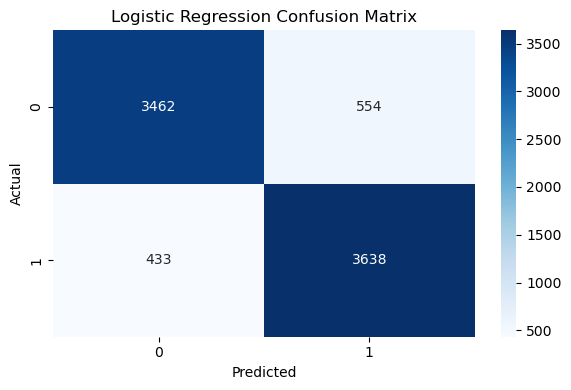

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      4016
           1       0.88      0.88      0.88      4071

    accuracy                           0.88      8087
   macro avg       0.88      0.88      0.88      8087
weighted avg       0.88      0.88      0.88      8087



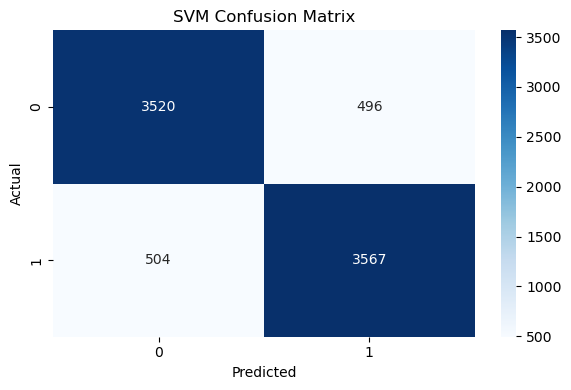

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      4016
           1       0.81      0.82      0.82      4071

    accuracy                           0.81      8087
   macro avg       0.81      0.81      0.81      8087
weighted avg       0.81      0.81      0.81      8087



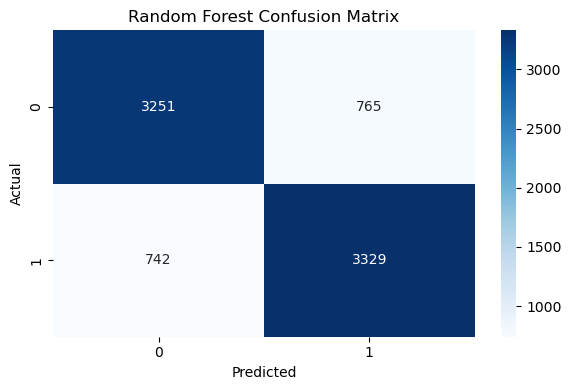

c:\Users\hamza\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[12:37:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      4016
           1       0.85      0.89      0.87      4071

    accuracy                           0.86      8087
   macro avg       0.86      0.86      0.86      8087
weighted avg       0.86      0.86      0.86      8087



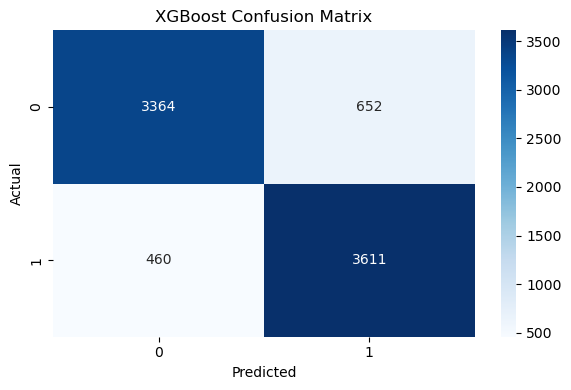

In [10]:
# Function to train and evaluate models using best Optuna parameters
def train_and_evaluate_models():
    # Define models with best hyperparameters from Optuna studies
    models = {
        'Logistic Regression': LogisticRegression(**study_logistic.best_params, max_iter=1000),
        'SVM': SVC(**study_svc.best_params),
        'Random Forest': RandomForestClassifier(**study_rf.best_params),
        'XGBoost': XGBClassifier(**study_xgb.best_params, use_label_encoder=False, eval_metric='logloss')
    }

    # Train and evaluate each model
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train_tfidf, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test_tfidf)
        
        # Print classification report
        print(f'{model_name} Classification Report:\n{classification_report(y_test, y_pred)}')
        
        # Compute and plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

# Call the evaluation function
train_and_evaluate_models()

In [11]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)